In [1]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "../dataset"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=50,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15)


train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(120, 120),
    class_mode='categorical',
    batch_size=16,
    subset='training'
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(120, 120),
    class_mode='categorical',
    batch_size=16,
    subset='validation'
)

Found 383 images belonging to 4 classes.
Found 66 images belonging to 4 classes.


In [74]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(120, 120, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [75]:
model.summary()

lr = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, train_generator.samples // 16, 0.95)

model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 118, 118, 64)      1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 57, 57, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 26, 128)      

In [76]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=14),
    tf.keras.callbacks.ModelCheckpoint("cycle_classifier_proto_2.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit_generator(
    train_generator,
    epochs=60,
    steps_per_epoch=train_generator.samples // 16,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 16,
    callbacks=callbacks,
)


Epoch 1/60
23/23 [==============================] - 8s 334ms/step - loss: 1.3149 - accuracy: 0.4251 - val_loss: 1.3471 - val_accuracy: 0.4688
Epoch 2/60
23/23 [==============================] - 8s 360ms/step - loss: 1.2311 - accuracy: 0.4796 - val_loss: 1.3752 - val_accuracy: 0.1875
Epoch 3/60
23/23 [==============================] - 10s 423ms/step - loss: 1.2681 - accuracy: 0.4741 - val_loss: 1.2828 - val_accuracy: 0.4688
Epoch 4/60
23/23 [==============================] - 13s 562ms/step - loss: 1.2354 - accuracy: 0.4659 - val_loss: 1.3509 - val_accuracy: 0.3594
Epoch 5/60
23/23 [==============================] - 11s 483ms/step - loss: 1.1546 - accuracy: 0.5259 - val_loss: 1.3099 - val_accuracy: 0.4531
Epoch 6/60
23/23 [==============================] - 12s 502ms/step - loss: 1.0641 - accuracy: 0.5777 - val_loss: 1.3233 - val_accuracy: 0.4375
Epoch 7/60
23/23 [==============================] - 10s 434ms/step - loss: 1.0642 - accuracy: 0.5462 - val_loss: 1.2557 - val_accuracy: 0.4531
E

In [152]:
model.save("cycle_classifier_proto.h5")

Text(0.5, 1.0, 'Training and validation loss')

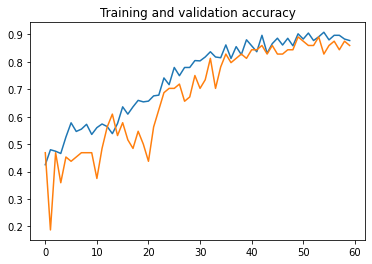

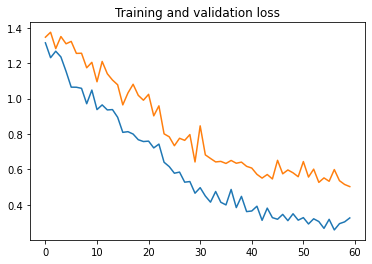

In [77]:
%matplotlib inline

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict_generator(validation_generator, validation_generator.samples // 16+1)
y_pred = np.argmax(Y_pred, axis=1)

In [78]:
Y_pred

array([[6.97095156e-01, 8.52762833e-02, 1.11023001e-01, 1.06605604e-01],
       [3.23792847e-06, 1.67425856e-01, 8.67710076e-03, 8.23893845e-01],
       [4.73359413e-03, 4.24937233e-02, 5.77173010e-02, 8.95055413e-01],
       [6.58542989e-03, 1.01405487e-04, 8.81063223e-01, 1.12249903e-01],
       [2.76889132e-05, 2.89339989e-01, 1.16366126e-01, 5.94266176e-01],
       [6.67649209e-02, 6.56115869e-03, 7.51206100e-01, 1.75467864e-01],
       [1.33909285e-01, 1.97466597e-05, 8.53803396e-01, 1.22675896e-02],
       [1.20067127e-01, 1.11822644e-03, 8.12576950e-01, 6.62377402e-02],
       [3.54973162e-10, 9.99203980e-01, 4.46021768e-05, 7.51457934e-04],
       [1.40746987e-08, 3.66898882e-03, 3.74986194e-02, 9.58832383e-01],
       [4.13125323e-04, 1.04452204e-03, 8.48857284e-01, 1.49685040e-01],
       [5.29022396e-01, 5.35971262e-02, 2.67502666e-01, 1.49877757e-01],
       [4.34967751e-09, 5.52372634e-02, 2.68379122e-01, 6.76383615e-01],
       [1.81036592e-02, 4.92998806e-04, 9.11966681e

In [45]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 2  1  6  5]
 [ 0  1  4  2]
 [ 5  3 17  5]
 [ 3  3  8  1]]


In [43]:
print('Classification Report')
target_names = ['Autre', 'Organique', 'Recyclable', 'Verre']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Autre       0.17      0.14      0.15        14
   Organique       0.10      0.14      0.12         7
  Recyclable       0.45      0.50      0.48        30
       Verre       0.09      0.07      0.08        15

    accuracy                           0.29        66
   macro avg       0.20      0.21      0.21        66
weighted avg       0.27      0.29      0.28        66



Pistes d'améliorations rapides:
- contrer le déséquilibre des classes (https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9)
- utiliser du transfer learning pour commencer avec un modèle plus robuste et déjà entrainé (DenseNet, ResNet, VGG16, EfficientNet)
- équilibrer le dataset en rajoutant/retirant des images

In [123]:
model_DN121 = tf.keras.Sequential([tf.keras.applications.MobileNetV2(weights='imagenet',
                                                                     input_shape=(120, 120, 3),
                                                                     include_top=False,
                                                                     pooling='max'
                                                                    ),
                                 tf.keras.layers.Dense(4, activation='softmax')])

In [124]:
model_DN121.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=3, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lr_schedule = tf.keras.callbacks.LearningRateScheduler(build_lrfn(), verbose=1)

In [127]:
%%time
history = model_DN121.fit_generator(
    train_generator,
    epochs=15,
    steps_per_epoch=train_generator.samples // 16,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 16,
    callbacks=[lr_schedule],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
24/24 [==============================] - 63s 3s/step - loss: 4.2799 - accuracy: 0.2135 - val_loss: 4.8999 - val_accuracy: 0.1562

Epoch 00002: LearningRateScheduler reducing learning rate to 2.3333333333333336e-05.
Epoch 2/15
24/24 [==============================] - 13s 538ms/step - loss: 2.7172 - accuracy: 0.3594 - val_loss: 4.8779 - val_accuracy: 0.1094

Epoch 00003: LearningRateScheduler reducing learning rate to 3.666666666666667e-05.
Epoch 3/15
24/24 [==============================] - 13s 542ms/step - loss: 1.6043 - accuracy: 0.5365 - val_loss: 5.5854 - val_accuracy: 0.1562

Epoch 00004: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 4/15
24/24 [==============================] - 32s 1s/step - loss: 1.1172 - accuracy: 0.6745 - val_loss: 5.7092 - val_accuracy: 0.0938

Epoch 00005: LearningRateSchedule

In [20]:
model_DN121.save("cycle_classifier_DN121.h5")

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model_DN121.predict_generator(validation_generator, validation_generator.samples // 16+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['Autre', 'Organique', 'Recyclable', 'Verre']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[2 2 4 2]
 [0 1 2 2]
 [6 1 6 7]
 [4 1 4 1]]
Classification Report
              precision    recall  f1-score   support

       Autre       0.17      0.20      0.18        10
   Organique       0.20      0.20      0.20         5
  Recyclable       0.38      0.30      0.33        20
       Verre       0.08      0.10      0.09        10

    accuracy                           0.22        45
   macro avg       0.21      0.20      0.20        45
weighted avg       0.24      0.22      0.23        45



In [98]:
model = tf.keras.models.load_model("cycle_classifier_proto_2.h5")

In [99]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

7608048

In [25]:
from PIL import Image
import tensorflow as tf
import numpy as np

In [26]:
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

In [27]:
im = Image.open('../dataset/verre/biere_25.jpg')
im_resized = im.resize((120, 120))
#arr = tf.keras.preprocessing.image.img_to_array(im_resized)
data = list(im_resized.getdata())
arr = np.asarray(data, dtype="float32") 
arr = np.reshape(arr, (1, 120, 120 , 3))

In [28]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_data = arr
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [29]:
tflite_results

array([[0., 0., 1., 0.]], dtype=float32)

In [117]:
model.predict(arr)

array([[0., 0., 1., 0.]], dtype=float32)